## Load libraries

In [3]:
library(tidyverse)
library(anomalize)

## Load the Data

In [4]:
tb = read_csv("../../data/NYCHA_TS.csv")
tb = select(tb, c('Building_Meter', 'Month', 'Imputed_KWH'))

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_double(),
  Building_Meter = col_character(),
  Month = col_date(format = ""),
  Month_Type = col_character(),
  `Month_#_Days` = col_double(),
  Prorated_Days = col_double(),
  Gap_Days = col_double(),
  Gap_Type = col_character(),
  Prorated_KWH = col_double(),
  Imputed_KWH = col_double()
)


## Explore the Anomalize package

### Example 1 - Account with no missing data

#### Method 1: STL + IQR

In [5]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = "STL", merge = TRUE) %>%
    anomalize(remainder, method = 'iqr') %>%
    time_recompose()

# ts_anomalized %>% glimpse()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


In [6]:
filter(ts_anomalized, anomaly == 'Yes')

Building_Meter,Month,Imputed_KWH,observed,season,trend,remainder,remainder_l1,remainder_l2,anomaly,recomposed_l1,recomposed_l2
165.0 - BLD 03_90327795,2012-11-01,82710.3,82710.3,-12265.34,150984.3,-56008.64,-23528,23388.25,Yes,115190.9,162107.2
165.0 - BLD 03_90327795,2014-07-01,177073.8,177073.8,49841.16,153031.5,-25798.86,-23528,23388.25,Yes,179344.6,226260.9
165.0 - BLD 03_90327795,2016-08-01,222030.0,222030.0,34686.26,156279.1,31064.60,-23528,23388.25,Yes,167437.4,214353.7


#### Plot the time series with the identified outliers4

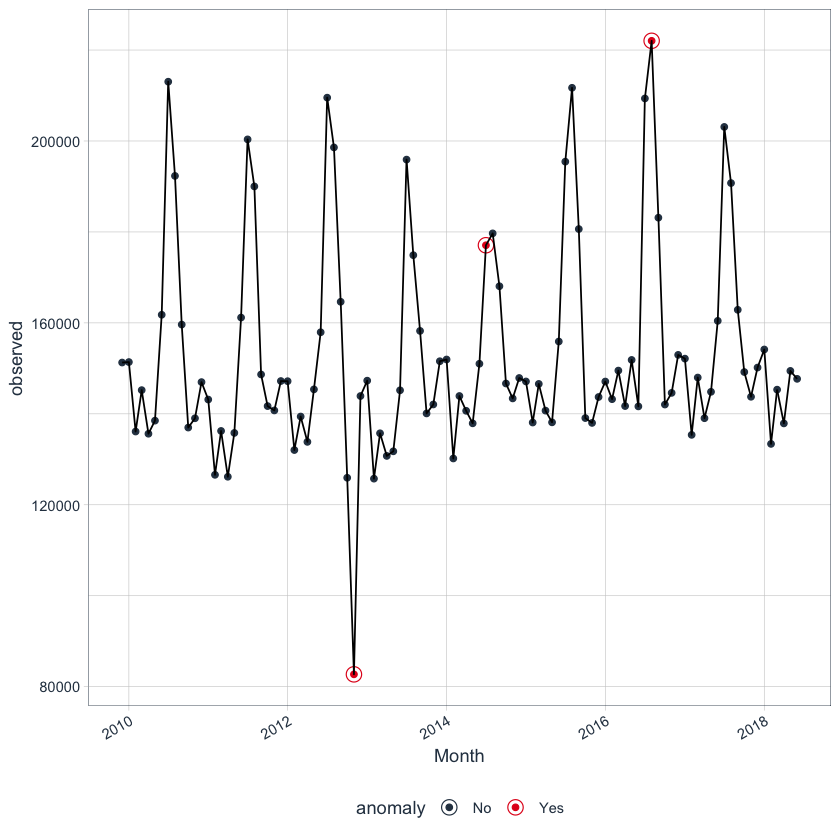

In [7]:
ts_anomalized %>%
    plot_anomalies(alpha_dots = 1) + geom_line()

#### Plot the decomposed results

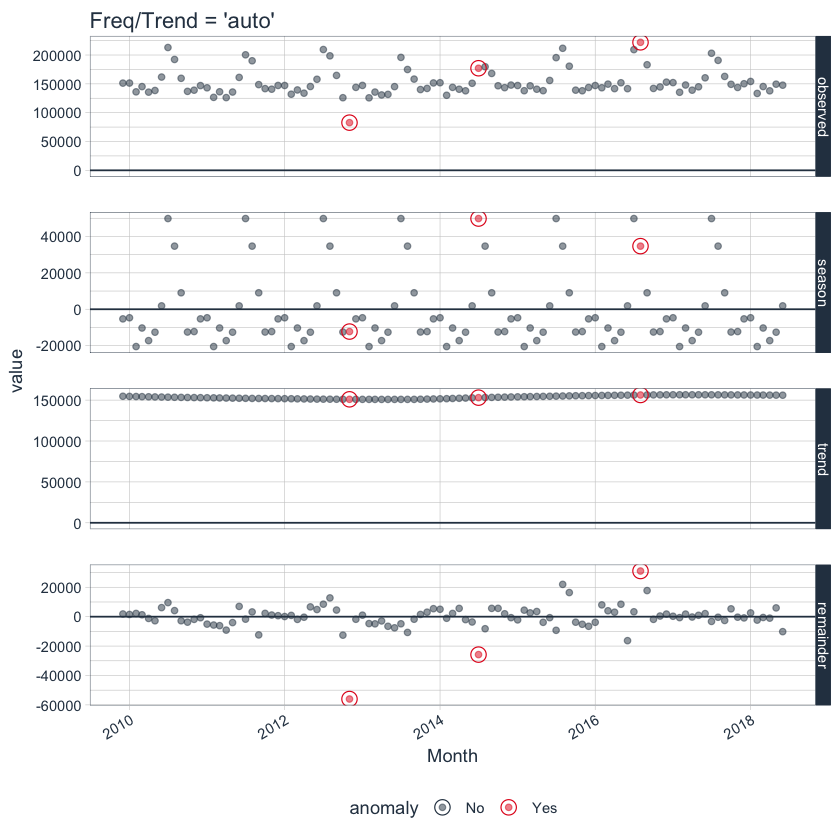

In [9]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'")

p1

#### Method 2: Twitter + GESD

In [11]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = "twitter", merge = TRUE) %>%
    anomalize(remainder, method = 'gesd') %>%
    time_recompose()

# ts_anomalized %>% glimpse()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


The Twitter decomposition method returns more outilers than the original STL method.

In [12]:
filter(ts_anomalized, anomaly == 'Yes')

Building_Meter,Month,Imputed_KWH,observed,season,median_spans,remainder,remainder_l1,remainder_l2,anomaly,recomposed_l1,recomposed_l2
165.0 - BLD 03_90327795,2012-11-01,82710.3,82710.3,-12508.822,144548.5,-49329.365,-7960.897,7960.897,Yes,124078.8,140000.6
165.0 - BLD 03_90327795,2013-08-01,174890.0,174890.0,39178.342,144548.5,-8836.832,-7960.897,7960.897,Yes,175765.9,191687.7
165.0 - BLD 03_90327795,2014-07-01,177073.8,177073.8,49199.121,147692.3,-19817.651,-7960.897,7960.897,Yes,188930.5,204852.3
165.0 - BLD 03_90327795,2016-06-01,141632.4,141632.4,2482.649,147692.3,-8542.575,-7960.897,7960.897,Yes,142214.1,158135.9
165.0 - BLD 03_90327795,2016-08-01,222030.0,222030.0,39178.342,147692.3,35159.351,-7960.897,7960.897,Yes,178909.8,194831.5
165.0 - BLD 03_90327795,2016-09-01,183134.8,183134.8,8316.164,147692.3,27126.328,-7960.897,7960.897,Yes,148047.6,163969.4


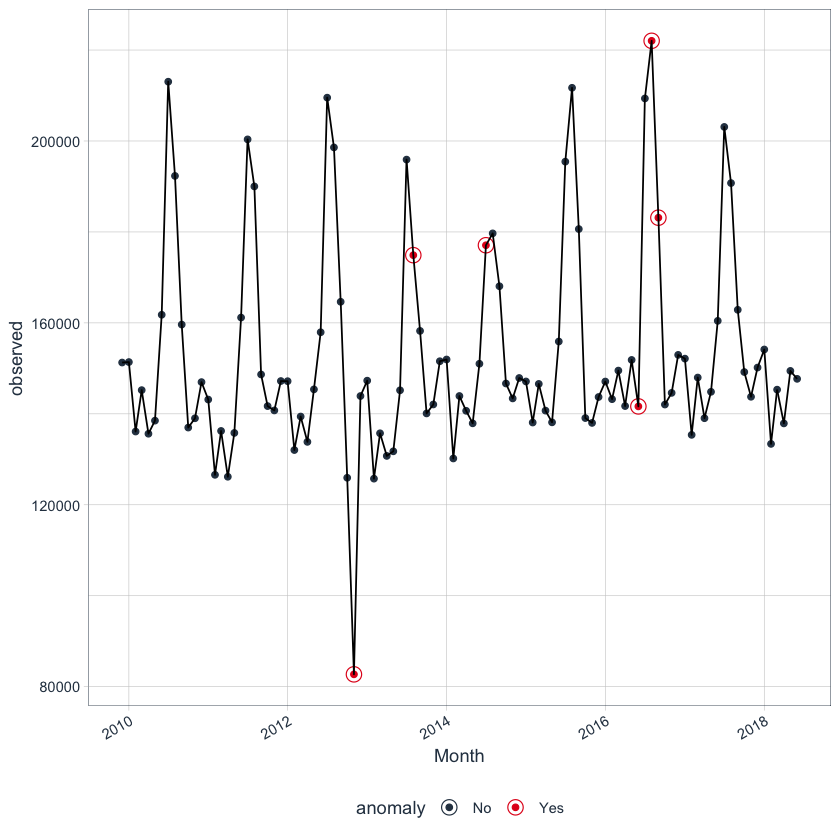

In [14]:
ts_anomalized %>%
    plot_anomalies(alpha_dots = 1) + geom_line()

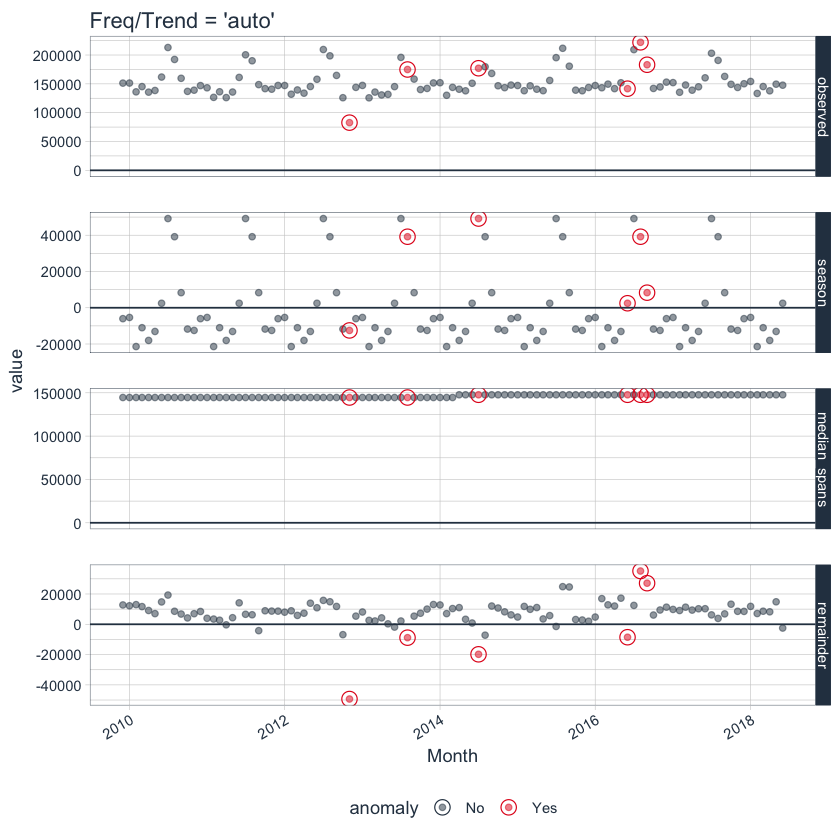

In [15]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'")

p1

### Adjust the max_anoms parameter

#### STL + IQR

In [17]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = "STL", merge = TRUE) %>%
    anomalize(remainder, method = 'iqr', max_anoms = (sum(ts$Imputed_KWH == 0) + 2)/nrow(ts)) %>%
    time_recompose()

# ts_anomalized %>% glimpse()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


By specifying the max number of outliers allowed, we get exactly the amount of outliers specified. The algorithm returns data points that have the largest absolute deviations in the residual component. 

In [19]:
filter(ts_anomalized, anomaly == 'Yes')

Building_Meter,Month,Imputed_KWH,observed,season,trend,remainder,remainder_l1,remainder_l2,anomaly,recomposed_l1,recomposed_l2
165.0 - BLD 03_90327795,2012-11-01,82710.3,82710.3,-12265.34,150984.3,-56008.64,-23528,23388.25,Yes,115190.9,162107.2
165.0 - BLD 03_90327795,2016-08-01,222030.0,222030.0,34686.26,156279.1,31064.60,-23528,23388.25,Yes,167437.4,214353.7


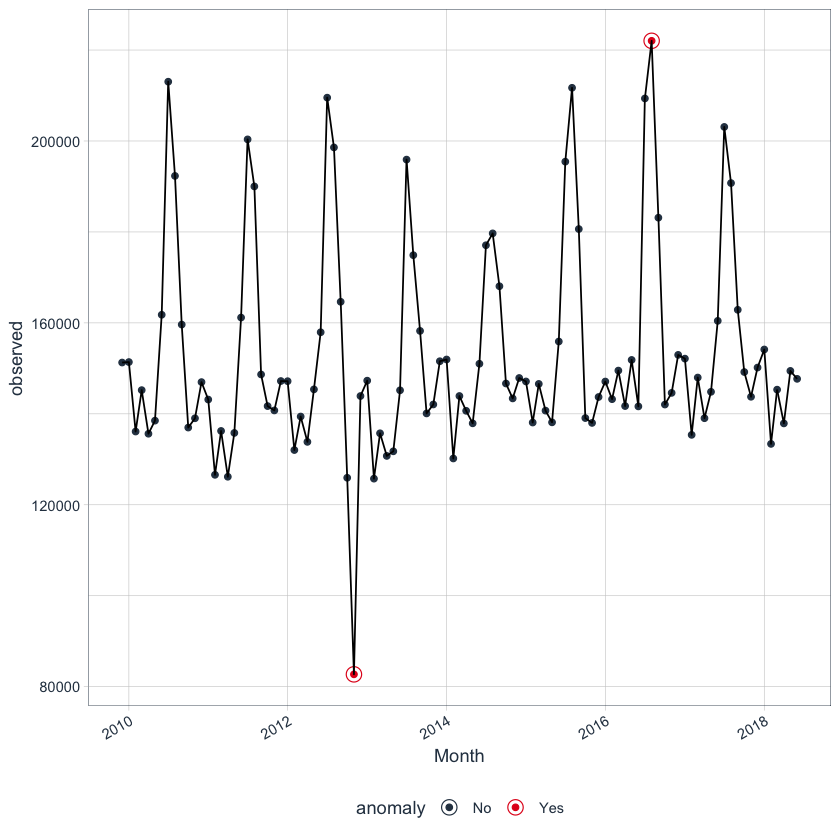

In [20]:
ts_anomalized %>%
    plot_anomalies(alpha_dots = 1) + geom_line()

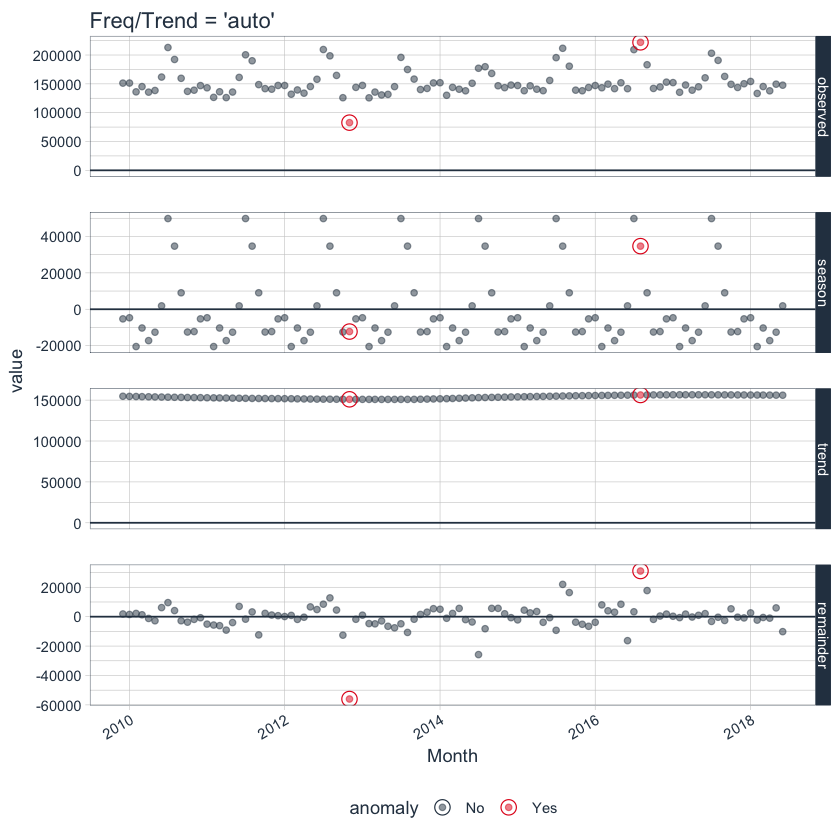

In [21]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'")

p1

### Example 2 - Account with three missing values in the middle (works better than the Twitter library)

#### Method: STL + IQR

In [23]:
ts =  select(filter(tb, Building_Meter == '164.0 - BLD 01_96973681'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = 'stl', merge = TRUE) %>%
    anomalize(remainder, method = 'iqr') %>%
    time_recompose()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


In [24]:
filter(ts_anomalized, anomaly == 'Yes')

Building_Meter,Month,Imputed_KWH,observed,season,trend,remainder,remainder_l1,remainder_l2,anomaly,recomposed_l1,recomposed_l2
164.0 - BLD 01_96973681,2012-11-01,64020.36,6.402036e+04,-3596.0013,97378.53,-29762.17,-23658.08,23760.54,Yes,70124.45,117543.1
164.0 - BLD 01_96973681,2013-01-01,0.00,-6.366463e-12,447.0866,97336.85,-97783.94,-23658.08,23760.54,Yes,74125.86,121544.5
164.0 - BLD 01_96973681,2013-02-01,0.00,1.818989e-12,-11446.9268,97316.01,-85869.08,-23658.08,23760.54,Yes,62211.00,109629.6
164.0 - BLD 01_96973681,2013-03-01,0.00,2.728484e-12,-5029.7667,97295.17,-92265.40,-23658.08,23760.54,Yes,68607.32,116025.9


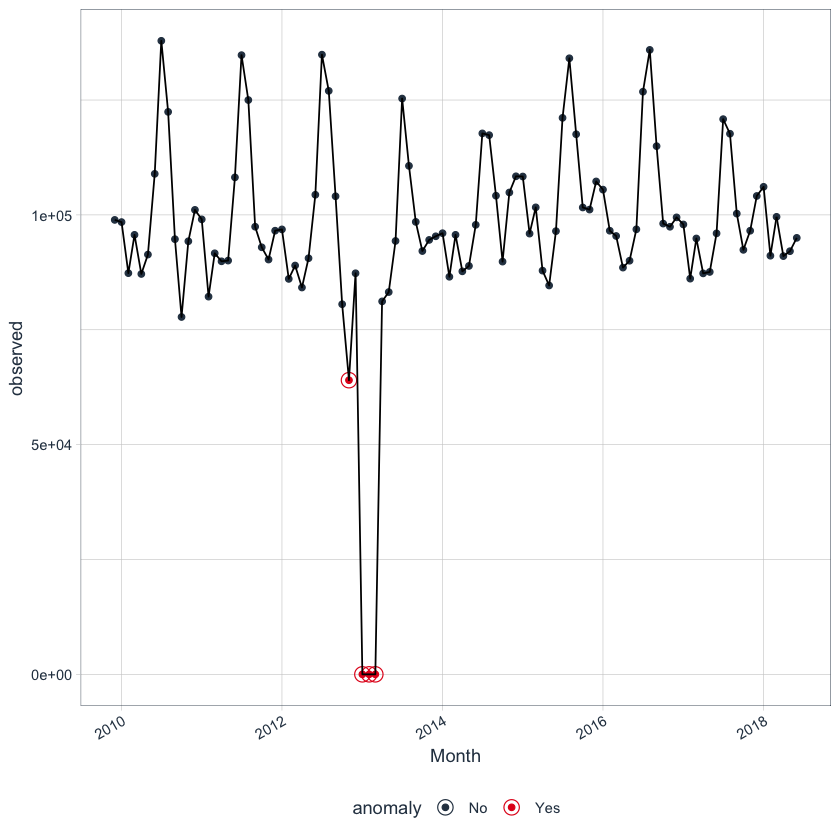

In [25]:
ts_anomalized %>%
    plot_anomalies(alpha_dots = 1) + geom_line()

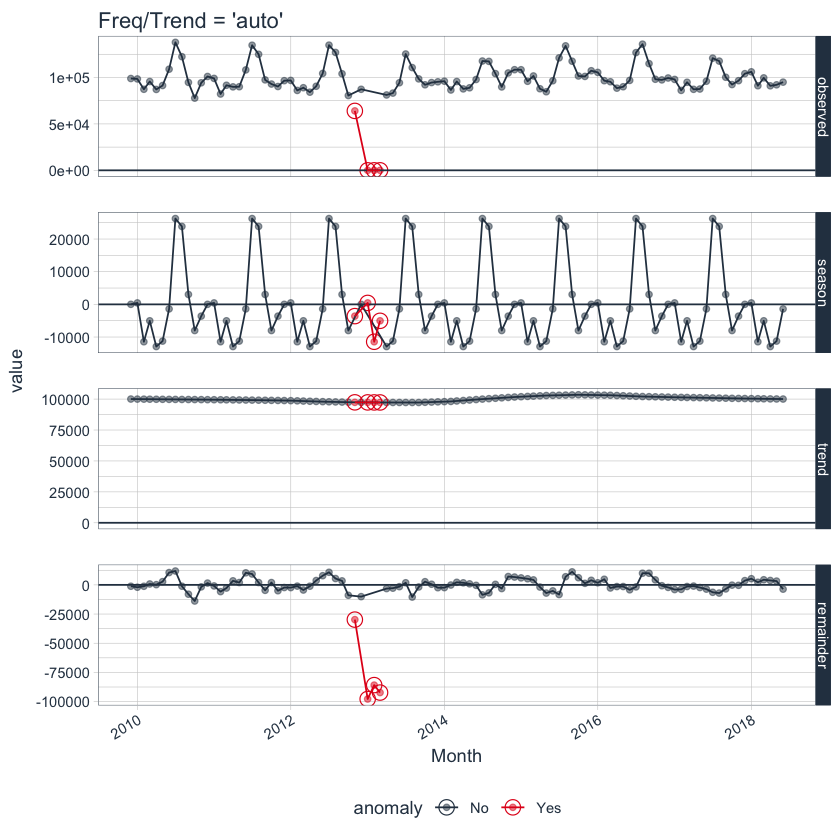

In [26]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'") + geom_line()

p1

#### Method: Twitter + GESD

In [27]:
ts =  select(filter(tb, Building_Meter == '164.0 - BLD 01_96973681'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = 'twitter', merge = TRUE) %>%
    anomalize(remainder, method = 'gesd') %>%
    time_recompose()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


In [28]:
filter(ts_anomalized, anomaly == 'Yes')

Building_Meter,Month,Imputed_KWH,observed,season,median_spans,remainder,remainder_l1,remainder_l2,anomaly,recomposed_l1,recomposed_l2
164.0 - BLD 01_96973681,2012-11-01,64020.36,6.402036e+04,-3732.39396,94440,-26687.24,-12767.11,12767.11,Yes,77940.50,103474.71
164.0 - BLD 01_96973681,2013-01-01,0.00,1.918465e-12,78.54968,94440,-94518.55,-12767.11,12767.11,Yes,81751.44,107285.66
164.0 - BLD 01_96973681,2013-02-01,0.00,1.818989e-12,-11921.57764,94440,-82518.42,-12767.11,12767.11,Yes,69751.31,95285.53
164.0 - BLD 01_96973681,2013-03-01,0.00,9.094947e-13,-5461.12432,94440,-88978.88,-12767.11,12767.11,Yes,76211.77,101745.98


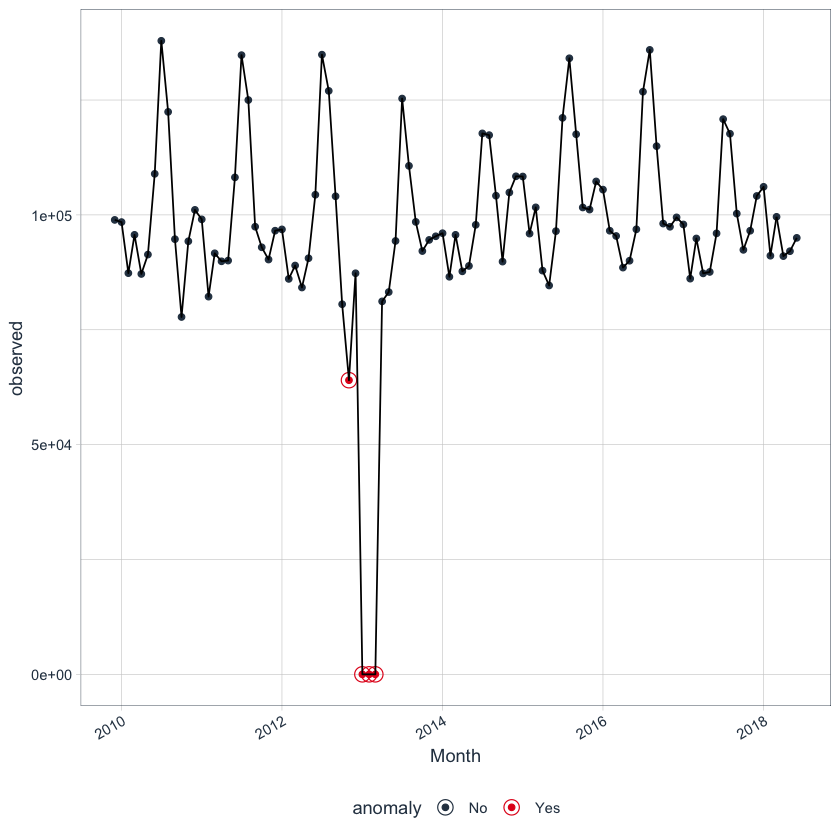

In [29]:
ts_anomalized %>%
    plot_anomalies(alpha_dots = 1) + geom_line()

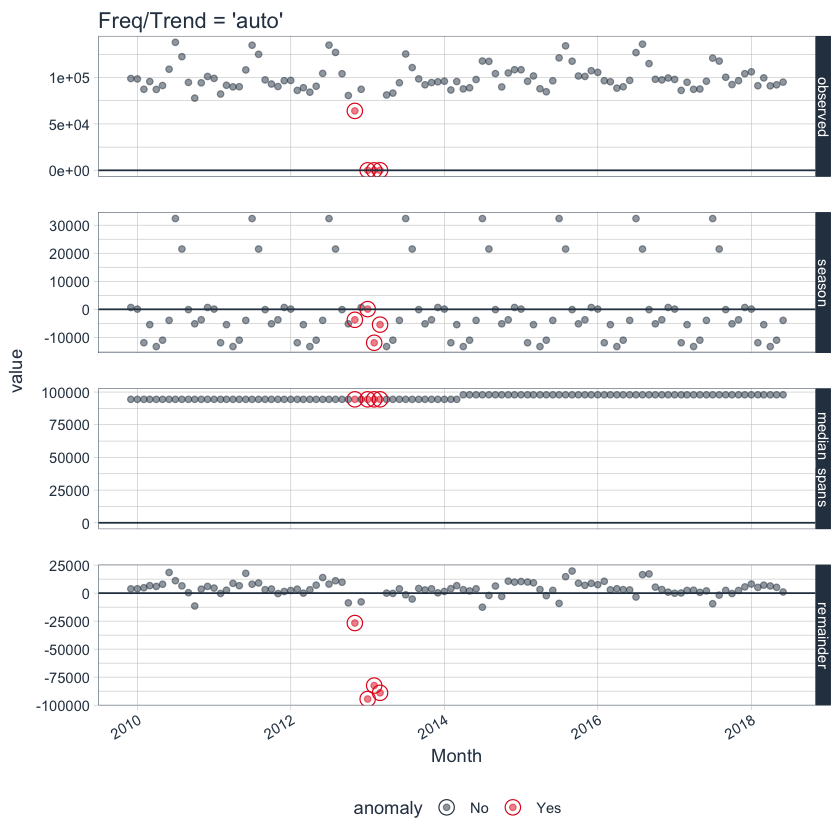

In [31]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'")

p1

### Loop through all accounts (with at least 3 years of data)

We can do the following parameters tuning for each account:
- Twitter vs. STL decomposition method
- IQR vs. GESD test on residuals
- max_anom for the upper limit of number of outliers
- others

For now, we just use the default setting and same parameter configurations for all accounts.

Only consider accounts with more than 3 years of data

In [32]:
accounts = tb %>% group_by(Building_Meter) %>% summarise(counts = n())
accounts = filter(accounts, counts >= 36)$Building_Meter

In [33]:
length(accounts)

[1] 2355

In [158]:
results <- vector("list", length(accounts)) 
points <- rep(NA, length(accounts))
anoamly_counts <- rep(NA, length(accounts))

In [170]:
start.time <- Sys.time()

for (i in 1:length(accounts)) {
# for (i in 1:2) {
    ts = select(filter(tb, Building_Meter == accounts[[i]]), 'Month', 'Imputed_KWH')
    num_zeros = sum(ts$Imputed_KWH == 0)
    ts_anomalized <- ts %>%
        time_decompose(Imputed_KWH, merge = TRUE) %>%
        anomalize(remainder, max_anom = ((nrow(ts) - num_zeros) * 0.2 + num_zeros)/(nrow(ts))) %>%
#         anomalize(remainder) %>%
        time_recompose()
    ts_anomalized$Account = accounts[[i]]
    results[[i]] <- ts_anomalized
    points[i] <- dim(ts_anomalized)[1]
    anoamly_counts[i] <- dim(filter(ts_anomalized, anomaly == 'Yes'))[1]
}

end.time <- Sys.time()
time.taken <- end.time - start.time

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 19 months
Converting

frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

frequency = 12 months
trend = 25 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 36.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 37 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 24.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
freque

frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23 months
Conv

frequency = 12 months
trend = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 36 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 36 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 36 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 25 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 17 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting

frequency = 12 months
trend = 31.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 31.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 20 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 31.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
freq

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 24 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 25 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 25 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Conver

frequency = 12 months
trend = 31.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 31.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 19 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 31 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
freq

trend = 28.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 10.5 months
trend = 20.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 45.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
tr

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 8 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting 

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 20 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
trend = 18 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 28.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 15 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 15 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
freque

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 25 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting

frequency = 12 months
trend = 27 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 24.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequenc

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 24 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 24 mon

frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 29 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequenc

frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index 

trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42

frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 46.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequenc

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Conver

frequency = 12 months
trend = 44.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
freq

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42.5 months


Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

trend = 21.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 37 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 37 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 36 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 37 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 36 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50 months
Converting

frequency = 12 months
trend = 16 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 10 months
trend = 18.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 10 months
trend = 18.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 29 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
freque

Time difference of 3.532687 mins

In [176]:
time.taken

Time difference of 3.532687 mins

### Summary of the % of anomalies detected

In [175]:
summary = data.frame('points' = points, 'anomalies' = anoamly_counts)
summary$perc = summary$anomalies / summary$points
summary(summary$perc)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.02913 0.07767 0.08853 0.13592 0.42222 

### Impute the missing values with the Forecast package (incomplete)

In [ ]:
library(forecast)

In [ ]:
ts = select(filter(tb, Building_Meter == accounts[[2]]), 'Month', 'Imputed_KWH')
ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, merge = TRUE) %>%
    anomalize(remainder) %>%
    time_recompose()

In [ ]:
x = select(ts_anomalized, c('Imputed_KWH'))

In [ ]:
x

In [ ]:
x = x$Imputed_KWH

In [ ]:
fit <- nnetar(tsclean(x))

In [ ]:
fit$size

In [ ]:
fit

### Test the case of level shift (Twitter + GESD can handle cases where there are two levels in the time series, but not a level shift in between)

#### Level shift in the middle

In [165]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

idx_outliers <- seq(50, 70)
ts$Imputed_KWH[idx_outliers] <- ts$Imputed_KWH[idx_outliers] + mean(ts$Imputed_KWH)/2

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = "Twitter", merge = TRUE) %>%
    anomalize(remainder, method = 'gesd') %>%
    time_recompose()

# ts_anomalized %>% glimpse()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


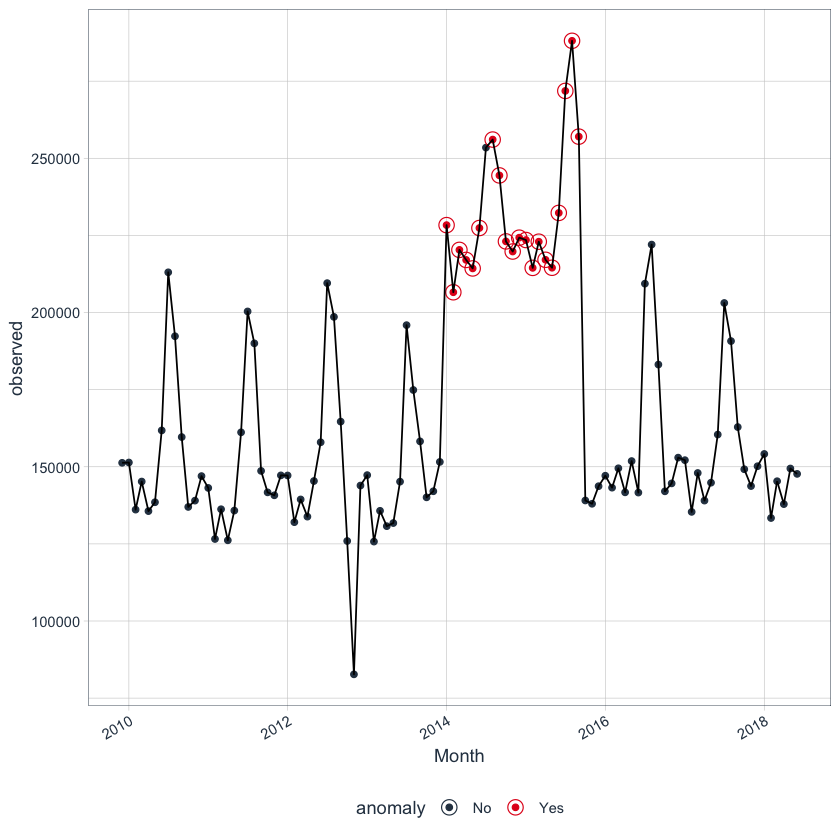

In [167]:
ts_anomalized %>%
    plot_anomalies(alpha_dots = 1) + geom_line()

#### Level shift in the end

In [168]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

idx_outliers <- seq(50, length(ts))
ts$Imputed_KWH[idx_outliers] <- ts$Imputed_KWH[idx_outliers] + mean(ts$Imputed_KWH)/2

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = "Twitter", merge = TRUE) %>%
    anomalize(remainder, method = 'gesd') %>%
    time_recompose()

# ts_anomalized %>% glimpse()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


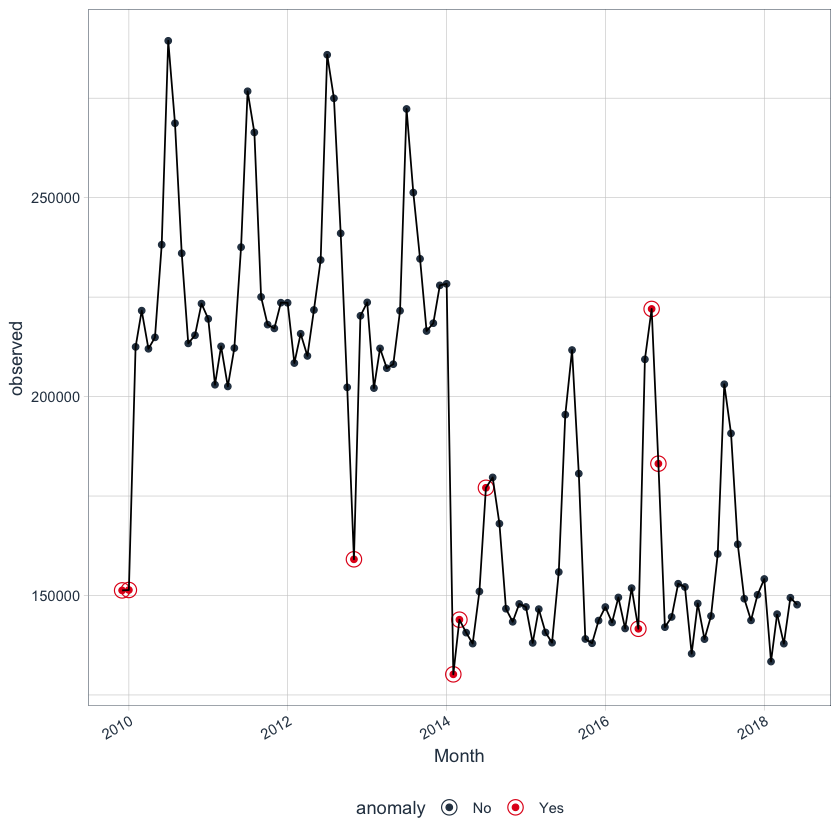

In [169]:
ts_anomalized %>%
    plot_anomalies(alpha_dots = 1) + geom_line()